# The Street View House Numbers (SVHN)


**import libraries**

In [216]:
from torch.utils.data import DataLoader
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


**Download DataSet** 

In [217]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = transforms.Compose([
    transforms.ToTensor(),
])
#Download DataSet 
train_data = datasets.SVHN(root='path_to_data', split='train', download=True, transform=transform)
test_data = datasets.SVHN(root='path_to_data', split='test', download=True, transform=transform)

Using downloaded and verified file: path_to_data\train_32x32.mat
Using downloaded and verified file: path_to_data\test_32x32.mat


**Load data in batches for training,test and evaluation**

In [219]:
train_loader = DataLoader(train_data, batch_size=100, shuffle=False)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False)

print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

Number of batches in train_loader: 733
Number of batches in test_loader: 261


**Calculate the mean and std (for normalize)**

In [228]:
def calculate_mean_std(data_loader):
    mean = 0
    std = 0
    total_images = 0

    for images, _ in data_loader:
        batch_images = images.size(0)  
        total_images += batch_images
        mean += images.mean(dim=(0, 2, 3)) * batch_images 
        std += images.std(dim=(0, 2, 3)) * batch_images   
    if total_images > 0: 
        mean /= total_images
        std /= total_images
    else:
        raise ValueError("DataLoader contains no images to calculate mean and std.")

    return mean, std

train_mean, train_std = calculate_mean_std(train_loader)


**Data Preprocessing and Augmentation for SVHN Dataset**


In [261]:
# Transformations for the training set - add variations to improve model generalization(Rotate the image randomly between,Randomly shift the image,add slight,add blur,normalize the image),convert to tensor
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-10, 10), fill=(0,)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std) 
])
# Transformations for the test set
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std),
    
])
# Transformations for the validation set
val_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

data_path = 'path_to_data'
# Load the full training data from the SVHN dataset (no transforms applied yet to keep the original images)

full_train_data = datasets.SVHN(root=data_path, split='train', download=False, transform=None)
# Load the test data from the SVHN dataset with the test_transform applied
test_data = datasets.SVHN(root=data_path, split='test', download=False, transform=test_transform)
# Split the full training data into training and validation sets
train_size = int(0.8 * len(full_train_data))
val_size = len(full_train_data) - train_size
train_dataset, val_dataset = random_split(full_train_data, [train_size, val_size])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False)

**CNN Architecture for Digit Recognition**

In [272]:
'''
Architecture:
1)Convolutional > Batch Normalization > ReLU > Max Pooling > Dropout
2)Convolutional > Batch Normalization > ReLU > Max Pooling > Dropout
3)Convolutional > Batch Normalization > ReLU > Max Pooling > Dropout
4)Convolutional > Batch Normalization > ReLU > Max Pooling > Dropout >SEBlock
5)Global Average Pooling
6)Fully Connected > ReLU > Dropout
'''
class CNNmodel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNmodel, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout(0.3)

        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2)
        self.dropout4 = nn.Dropout(0.3)
        self.se4 = SEBlock(256)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 512)  # Fully Connected עם 512 נוירונים
        self.dropout_fc1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)  # Fully Connected עם 256 נוירונים
        self.dropout_fc2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(256, num_classes)  # פלט עם num_classes
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.se4(x)
        x = self.dropout4(x)

        x = self.global_pool(x)  # Global Average Pooling
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_fc2(x)
        x = self.fc3(x)
        return x

#SEBlock - Squeeze and Excitation Block - A block that helps the model to focus on important features and ignore less important features
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)

    def forward(self, x):
        batch, channels, _, _ = x.size()
        y = self.global_pool(x).view(batch, channels)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(batch, channels, 1, 1)
        return x * y
# Early stopping class to stop the training process if the model is not improving
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.mode == 'min' and val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.mode == 'max' and val_loss > self.best_loss + self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

**Training**

Epoch [1/50], Train Loss: 2.1957, Train Accuracy: 18.58%, Val Loss: 1.8734, Val Accuracy: 32.08%
Epoch [2/50], Train Loss: 1.5813, Train Accuracy: 45.21%, Val Loss: 1.0936, Val Accuracy: 62.97%
Epoch [3/50], Train Loss: 1.1355, Train Accuracy: 62.64%, Val Loss: 0.7767, Val Accuracy: 76.13%
Epoch [4/50], Train Loss: 0.9448, Train Accuracy: 69.48%, Val Loss: 0.6150, Val Accuracy: 81.51%
Epoch [5/50], Train Loss: 0.8344, Train Accuracy: 73.58%, Val Loss: 0.5466, Val Accuracy: 83.37%
Epoch [6/50], Train Loss: 0.7505, Train Accuracy: 76.49%, Val Loss: 0.5030, Val Accuracy: 84.88%
Epoch [7/50], Train Loss: 0.7031, Train Accuracy: 78.17%, Val Loss: 0.4576, Val Accuracy: 86.36%
Epoch [8/50], Train Loss: 0.6580, Train Accuracy: 79.63%, Val Loss: 0.4287, Val Accuracy: 86.98%
Epoch [9/50], Train Loss: 0.6192, Train Accuracy: 80.86%, Val Loss: 0.4087, Val Accuracy: 87.72%
Epoch [10/50], Train Loss: 0.5892, Train Accuracy: 81.94%, Val Loss: 0.3879, Val Accuracy: 88.21%
Epoch [11/50], Train Loss: 0.

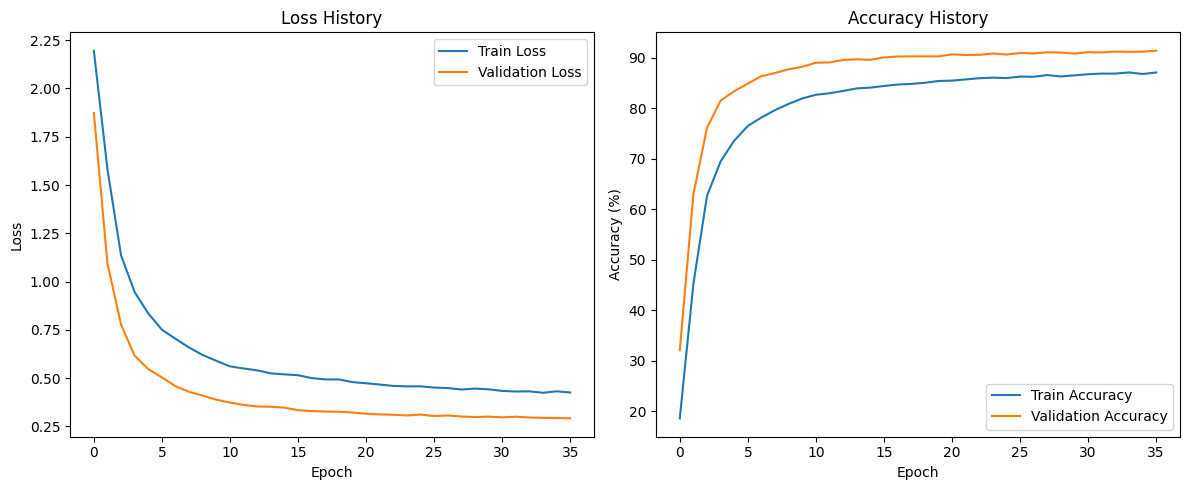

In [266]:
#Hyperparameters
learning_rate = 0.0001
num_epochs = 50
batch_size = 32

model = CNNmodel(num_classes=10).to(device)

class_weights = [1.5, 1.0, 1.0, 1.5, 1.0, 1.0, 2.5, 1, 2, 2.5] #Weights for each class to address class imbalance problem
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device)) #CrossEntropyLoss with class weights

optimizer = optim.Adam(model.parameters(), lr=learning_rate) #Adam optimizer 

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) #Learning rate scheduler to reduce the learning rate by half every 10 epochs

early_stopping = EarlyStopping(patience=7, min_delta=0.01, mode='min') #Early stopping to stop the training process if the model is not improving
#Store the loss and accuracy history for plotting
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
#Training loop
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    #Validation loop
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    #Print the loss and accuracy for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    early_stopping(val_loss)#Stop the training process if the model is not improving
    if early_stopping.early_stop:
        print("Early stopping!") 
        break
   
    scheduler.step()
#Plot the loss and accuracy history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy History')
plt.legend()

plt.tight_layout()
plt.show()



**Model Evaluation and Test Performance Report**

Test Loss: 0.3093, Test Accuracy: 91.18%


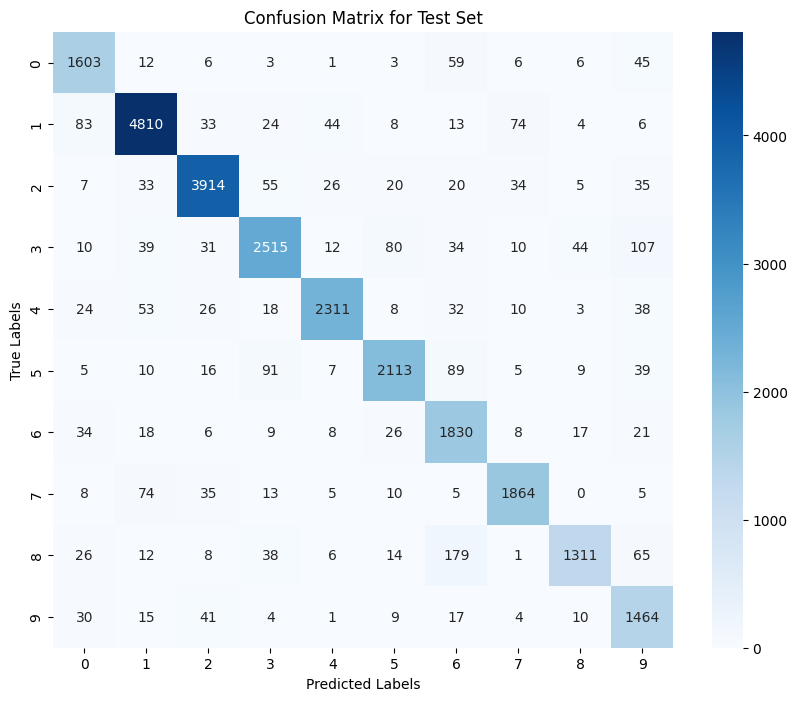

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.88      0.92      0.90      1744
     Class 1       0.95      0.94      0.95      5099
     Class 2       0.95      0.94      0.95      4149
     Class 3       0.91      0.87      0.89      2882
     Class 4       0.95      0.92      0.93      2523
     Class 5       0.92      0.89      0.90      2384
     Class 6       0.80      0.93      0.86      1977
     Class 7       0.92      0.92      0.92      2019
     Class 8       0.93      0.79      0.85      1660
     Class 9       0.80      0.92      0.86      1595

    accuracy                           0.91     26032
   macro avg       0.90      0.90      0.90     26032
weighted avg       0.91      0.91      0.91     26032



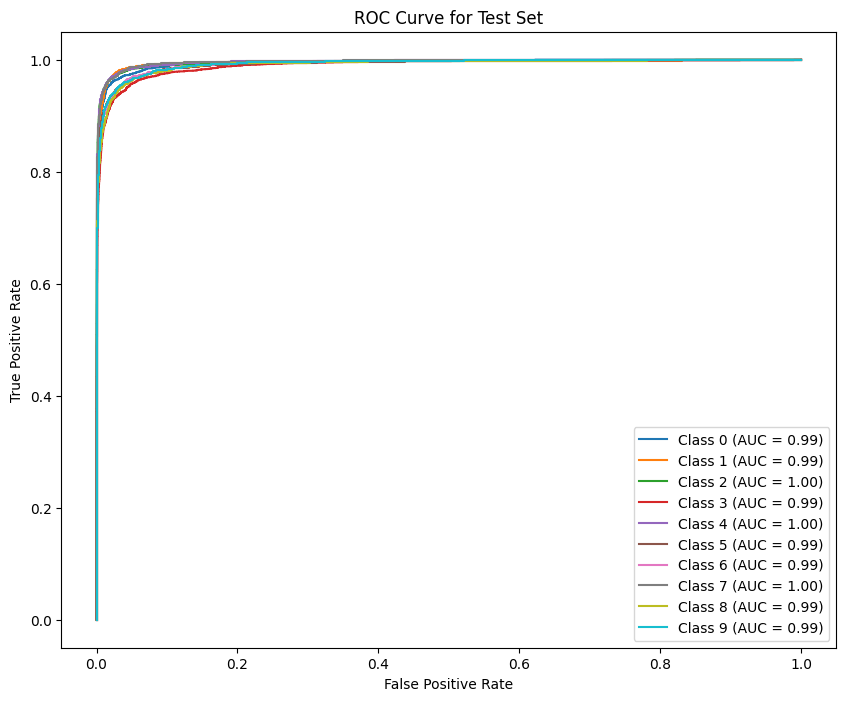

In [288]:
# Evaluate the model on the test set
model.eval() 
test_loss = 0.0
test_correct = 0
test_total = 0
all_labels = []
all_preds = []
all_probs = []  # Collect probabilities for ROC curve

# Test loop
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # Get logits from the model
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
        all_probs.extend(probs.cpu().numpy())  # Collect probabilities for ROC curve

        _, predicted = torch.max(outputs, 1)  # Get predicted classes
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
test_acc = 100 * test_correct / test_total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

# **Confusion Matrix**
conf_matrix = confusion_matrix(all_labels, all_preds)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(range(10)),  # Change to class names if available
            yticklabels=list(range(10)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Set')
plt.show()

# **Classification Report**
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(10)]))

# **ROC Curve**
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

binarized_labels = label_binarize(all_labels, classes=range(10))

all_probs = np.array(all_probs)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(10):  # Adjust based on the number of classes
    fpr, tpr, _ = roc_curve(binarized_labels[:, i], all_probs[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend()
plt.show()


**During the work on the model, we faced a few interesting challenges:**

Confusion between digits (like '9' as '6' or '3'):
The model sometimes confused '9' with '6' or '3' because of their visual similarity in certain orientations. This was something we needed to fix to improve accuracy.

**Imbalance in the dataset (too many '1's):**

We noticed there were many more images of the digit '1', which caused the model to predict '1' more often than it should. To solve this, we used class weights in the loss function, giving less common digits more importance. This helped balance the predictions.

**Image quality issues (blur and distortions):**

Some images were blurry or distorted, which led to wrong predictions. To handle this, we improved the data augmentation process by adding techniques like rotation, stretching, and slight shifts. This made the model more robust to such challenges.

*These adjustments helped the model perform much better and handle the challenges we found along the way.*